<a href="https://colab.research.google.com/github/ricoprediansyah/CV-FASTER_RCNN-MYFACE-GPU-TPU/blob/main/FASTER_RCNN_MY_FACE_GPU_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="PZMfN1gExhcqfGkkkd43")
project = rf.workspace("rico-prediansyah").project("myface-v1gul")
version = project.version(1)
dataset = version.download("voc")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MyFace-1 in voc:: 100%|██████████| 71/71 [00:00<00:00, 6798.83it/s]


In [ ]:
# Membuat folder images dan annotations
!mkdir -p images annotations

In [ ]:
import os
import shutil

# Daftar folder sumber
folders = ['/content/MyFace-1/test', '/content/MyFace-1/train', '/content/MyFace-1/valid']

# Membuat folder tujuan jika belum ada
os.makedirs('/content/images', exist_ok=True)
os.makedirs('/content/annotations', exist_ok=True)

# Memindahkan file berdasarkan ekstensi
for folder in folders:
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)

        # Memindahkan file .xml ke /content/annotations
        if filename.endswith('.xml'):
            shutil.move(file_path, '/content/annotations/')

        # Memindahkan file .png, .jpg, atau .jpeg ke /content/images
        elif filename.endswith(('.png', '.jpg', '.jpeg')):
            shutil.move(file_path, '/content/images/')


In [ ]:
import os
import random
import numpy as np
import shutil

# Menghitung dan mencetak jumlah file di folder annotations dan images
print(f'Jumlah file di annotations: {len(os.listdir("annotations"))}')
print(f'Jumlah file di images: {len(os.listdir("images"))}')

# Membuat folder test_images dan test_annotations
os.makedirs('test_images', exist_ok=True)
os.makedirs('test_annotations', exist_ok=True)

# Mengatur seed untuk reproducibility
random.seed(1234)

# Menghitung jumlah dataset
total_data = 33
test_data_count = 8

# Mengambil indeks secara acak untuk 8 data
idx = random.sample(range(total_data), test_data_count)

# Memindahkan file gambar ke test_images
for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move(os.path.join('images', img), os.path.join('test_images', img))

# Memindahkan file anotasi ke test_annotations
for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move(os.path.join('annotations', annot), os.path.join('test_annotations', annot))

# Menghitung dan mencetak jumlah file setelah pemindahan
print(f'Jumlah file di annotations setelah pemindahan: {len(os.listdir("annotations"))}')
print(f'Jumlah file di images setelah pemindahan: {len(os.listdir("images"))}')
print(f'Jumlah file di test_annotations: {len(os.listdir("test_annotations"))}')
print(f'Jumlah file di test_images: {len(os.listdir("test_images"))}')


Jumlah file di annotations: 33
Jumlah file di images: 33
Jumlah file di annotations setelah pemindahan: 25
Jumlah file di images setelah pemindahan: 25
Jumlah file di test_annotations: 8
Jumlah file di test_images: 8


In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [ ]:
def generate_box(obj):
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

In [ ]:
adjust_label = 0

def generate_label(obj):
    # Mengembalikan label 1 untuk class "Rico-Prediansyah"
    if obj.find('name').text == "Rico-Prediansyah":
        return 1 + adjust_label

    # Jika class tidak dikenali, kembalikan 0
    return 0 + adjust_label

In [ ]:
def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

In [ ]:
def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        else :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # define the path to the images and what transform will be used
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor() # ToTensor : convert numpy image to torch.Tensor type
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

In [ ]:
def get_model_instance_segmentation(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


In [ ]:
model = get_model_instance_segmentation(2) #1 class 1 backround

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 15
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 2.2661550045013428, time : 4.761007785797119
epoch : 2, Loss : 1.8243434429168701, time : 4.720871448516846
epoch : 3, Loss : 1.3191989660263062, time : 4.743950366973877
epoch : 4, Loss : 1.170928716659546, time : 4.768592119216919
epoch : 5, Loss : 0.9654101133346558, time : 4.773667573928833
epoch : 6, Loss : 0.9184978008270264, time : 4.841068744659424
epoch : 7, Loss : 0.75218665599823, time : 4.933972597122192
epoch : 8, Loss : 0.7278361916542053, time : 4.95658016204834
epoch : 9, Loss : 0.9231204986572266, time : 5.040569543838501
epoch : 10, Loss : 0.7444111704826355, time : 5.082063436508179
epoch : 11, Loss : 0.8324300050735474, time : 5.13874888420105
epoch : 12, Loss : 0.6254682540893555, time : 5.255102634429932
epoch : 13, Loss : 0.6353247165679932, time : 5.266910552978516
epoch : 14, Loss : 0.5219367742538452, time : 5.201257944107056
epoch : 15, Loss : 0.538253128528595, time : 5.12848734855

In [ ]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


<All keys matched successfully>

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold :
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad():
    # batch size of the test set = 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[264.7767, 123.2795, 409.8656, 317.8646]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9811], device='cuda:0')}, {'boxes': tensor([[264.9958, 211.5393, 366.4014, 406.4660]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9649], device='cuda:0')}]


Target :  tensor([1])


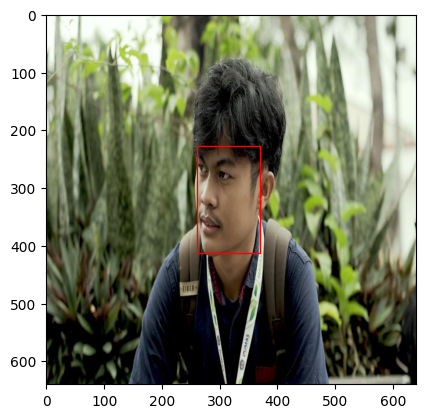

IndexError: list index out of range

In [ ]:
#INI UNTUK TPU / CPU

_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

Target :  tensor([1])


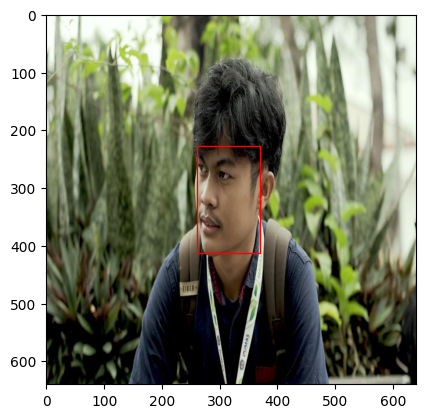

Prediction :  tensor([1])


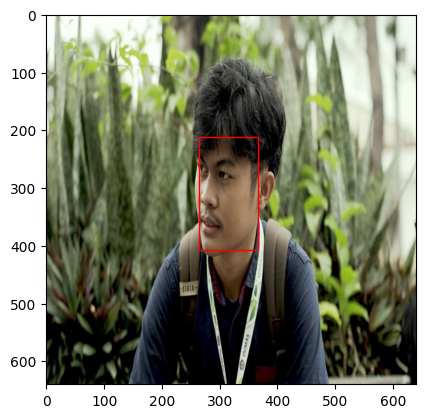

In [ ]:
#INI GPU

_idx = 1

# Pastikan tensor diubah menjadi numpy setelah dipindahkan ke CPU
print("Target : ", annotations[_idx]['labels'].cpu())  # Pindahkan labels ke CPU sebelum dicetak

# Pindahkan gambar ke CPU untuk visualisasi
imgs_cpu = imgs[_idx].cpu()

# Pindahkan setiap tensor di dalam annotations ke CPU
annotations_cpu = {k: v.cpu() for k, v in annotations[_idx].items()}

# Visualisasikan gambar dan anotasi (target)
plot_image_from_output(imgs_cpu, annotations_cpu)

# Pindahkan prediksi ke CPU
pred_cpu = {k: v.cpu() for k, v in pred[_idx].items()}

# Visualisasikan gambar dan prediksi
print("Prediction : ", pred_cpu['labels'])
plot_image_from_output(imgs_cpu, pred_cpu)


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


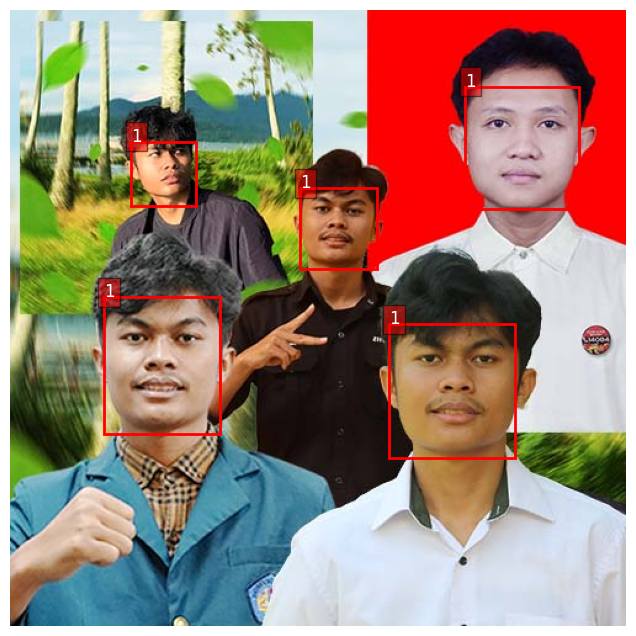

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms

# Pastikan model sudah dimuat dan berada dalam mode eval
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model_instance_segmentation(2)  # Menggunakan 2 kelas (1 objek + background)
model.load_state_dict(torch.load('model_15.pt'))  # Memuat model yang sudah dilatih
model.to(device)

def plot_image_with_boxes(image, boxes, labels):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    ax = plt.gca()
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, str(label.item()), fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

# Memuat gambar baru
img_path = '/content/sayaa.jpg'
image = Image.open(img_path).convert("RGB")
transform = transforms.ToTensor()
image_tensor = transform(image).unsqueeze(0).to(device)  # Mengubah menjadi tensor dan menambah dimensi batch

# Melakukan prediksi
model.eval()
with torch.no_grad():
    pred = model(image_tensor)

# Menentukan threshold untuk prediksi
threshold = 0.5
pred_boxes = []
pred_labels = []

# Menyaring prediksi berdasarkan skor
for idx in range(len(pred)):
    for i, score in enumerate(pred[idx]['scores']):
        if score > threshold:
            pred_boxes.append(pred[idx]['boxes'][i].cpu().numpy())
            pred_labels.append(pred[idx]['labels'][i].cpu().numpy())

# Menampilkan gambar asli dengan kotak prediksi
plot_image_with_boxes(image, pred_boxes, pred_labels)
